# Projet - Classification de documents d'opinions
---
- Un jeu de données textuelles est mis à disposition sur Moodle.  
- Il s'agit d'un corpus de 10.000 documents contenant des avis d'internautes sur des films.  
- A chaque document est associé sa polarité selon l'avis (+1 : positif, -1 : négatif).  
- Le fichier des documents est formaté dans un tableau csv (un avis par ligne), un autre fichier csv contient les polarités d'avis par document (-1/+1).  
- Une correspondance directe existe entre les numéros des lignes des documents et des polarités.

## Aperçu du module utility_ML.py
---
Le module `utility_ML.py` est utilisé pour externalizer les éléments de programmation utilitaires utilisées tout au long de notre projet. Ceci inclut :
1. Des **constantes** désignant des chemins vers les **ressources utilisées/créées** par le projet (*datasets, fichiers pickle, etc.*)
2. Des **constantes** désignant des **objets** utilisés dans le code du projet (*e.g. STOP_WORDS, POS_TAG_MAP, valeurs de paramétrage des fonctions utilisés dans le projet, etc.*)
3. Des **fonctions wrapper** pour les fonctions d'**importation, de fusion et de mélange de datasets*
4. Des **fonctions de prétraitement** (*e.g. remplacement des contractions, suppression de ponctuation, lemmatization, etc.*)
5. Des **classes utilitaires** utilisées dans le projet (*e.g. classe encapsulant les résultats d'une recheche par `GridSearch`*)

In [ ]:
#MODULES
import re
import unicodedata
import warnings

import pandas as pd
import numpy as np
import contractions
import inflect

from collections import defaultdict

from nltk import pos_tag
from nltk import punkt
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.base import TransformerMixin

warnings.filterwarnings('ignore', category=FutureWarning)

#DEFINITION OF SOME OF THE RESOURCES USED THROUGHOUT THIS NOTEBOOK
DATA_PATH = 'Datasets/dataset.csv'
TARGET_PATH = 'Datasets/labels.csv'
TEST_DATA_PATH = 'Datasets/test_data.csv'
TEST_TARGET_PATH = 'Datasets/test_labels.csv'
IMDB_DATA_PATH = 'Datasets/imdb_reviews_scores.csv'
GAUSSIANNB_PATH = 'Classifiers/gaussianNB.pkl'
LOGISTICREGRESSION_PATH = 'Classifiers/logisticRegression.pkl'

#stop words set adapted to the context of the dataset
STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS_EXCEPTIONS = set(('no', 'nor', 'not',))
STOP_WORDS_ADDITIONS = [
    'film', 'films', 'filmed',
    'movie', 'movies',
    'character', 'characters',
    'story', 'stories',
    'scene', 'scenes',
    'actor', 'actors', 'actress', 'actresses', 'act', 'acts', 'acted', 'acting'
    'direct', 'directs', 'directed', 'directing', 'director', 'directors',
    'script', 'scripts',
    'plot', 'plots'
]
STOP_WORDS.update(STOP_WORDS_ADDITIONS)
STOP_WORDS = STOP_WORDS - STOP_WORDS_EXCEPTIONS

#POS-TAG dictionary that will be used during the lemmatization process
POS_TAG_MAP = defaultdict(lambda : wn.NOUN)
POS_TAG_MAP['J'] = wn.ADJ
POS_TAG_MAP['V'] = wn.VERB
POS_TAG_MAP['R'] = wn.ADV

#parameters used by the cross validation score function
CV_SEED = 7 #seed used for random selection of partitions during cross validation
CV_SCORING = 'accuracy'

#parameters used by the training/set generator
TTS_VALIDATION_SIZE = 0.3 #30% of dataset used for training
TTS_TEST_SIZE = 1 - TTS_VALIDATION_SIZE #70% of dataset used for testing
TTS_SEED = 30 #seed used for random selection of training/test sets

#parameters used by the gridsearch function
GRDSR_SCORING = 'accuracy'

#DEFINITION OF IMPORTATION, MERGING AND SHUFFLING FUNCTIONS OF DATASETS
def import_dataset(dataset_path, importation_message=None, sep='\t', names=None):
    """
    imports a dataset from a given path

    returns the dataframe containing the imported dataset"""

    print("\n{}".format(importation_message))
    df = pd.read_csv(dataset_path, sep=sep, header=None, names=names, encoding='utf-8')
    print('Size : {}'.format(df.shape))
    print('Head of imported dataset :')
    display(df.head())

    return df

def merge_datasets(df1, df2):
    """
    merges datasets contained within dataframes df1 and df2

    returns a new dataframe containing the merged datasets"""

    df = df1.join(df2)

    print('Size : {}'.format(df.shape))
    print('Head of merged dataset :')
    display(df.head())

    return df

def shuffle_dataset(df):
    """
    shuffles dataset entries and reset indexes

    returns a new dataframe containing the shuffled dataset with the reset indexes"""

    shuffled_df = shuffle(df)
    shuffled_df.reset_index(inplace = True, drop = True)

    print('Head of shuffled dataset :')
    display(shuffled_df.head())

    return shuffled_df

#DEFINITION OF PREPROCESSING FUNCTIONS
def replace_contractions(document):
    """
    replaces contracted expressions in a document

    returns document with no contracted expressions"""
    return contractions.fix(document)

def remove_urls(document):
    """
    removes all urls in the document

    returns a document without any urls"""
    return re.sub(r'https?://(www\.)?[-\w@:%.\+~#=]{2,256}\.[a-z]{2,6}\b([-\w@:%_\+.~#?&/=;]*)', '', document)

def remove_empty_html_tags(document):
    """
    removes empty html tags like <br />, <hr />, etc.

    returns a document without filtered from empty html tags"""
    return re.sub(r'(<\w+\s*/?>)', ' ', document)

def clean_sentence_anchors(document):
    """
    cleans all sentences within a document, such that
    the end of a sentence and the beginning of a new one is separated by a period (or many)
    followed by a whitespace
    This cleaning is required because upon removing punctuation,
    some words get concatenated and create new meaningless terms

    example of a dirty document: "This is a dirty sentence.Another dirty sentence begins"
    cleaned version: "This is a cleaned sentence. Another cleaned sentence begins"

    This pattern repeats with a sentence ending with a lowercase/uppercase letter and
    another one beginning with a lowercase/uppercase letter
    The beginning sentence could also end with a digit and the next sentence could begin with
    a digit. Hence we get three different patterns:
    word.*word
    word.*digit
    digit.*word

    returns a document with cleaned sentences"""

    word_word = r'([a-zA-Z]+\.*)\.([a-zA-Z]+)' #word(.*)word pattern
    word_digit = r'([a-zA-Z]+\.*)\.(\d+)' #word(.*)digit pattern
    digit_word = r'(\d+\.*)\.([a-zA-Z]+)' #digit(.*)word pattern
    patterns = [
        word_word,
        word_digit,
        digit_word,
    ]

    for pattern in patterns:
        if re.search(pattern, document):
            document = re.sub(pattern, r'\1. \2', document)

    return document

def remove_non_ascii(tokens):
    """
    normalizes the tokens
    encodes tokens as ASCII characters from tokens
    and decodes as utf-8

    returns a list of normalized and encoded as ascii tokens"""
    return [unicodedata.normalize('NFKD', token)
           .encode('ascii', 'ignore')
           .decode('utf-8', 'ignore')
           for token in tokens]

def split_on_characterset(tokens, regex):
    """
    splits a token in tokens upon matching with the characterset defined by the regex
    and appends the tokens obtained from splitting the token to the tokens list

    returns a list of all tokens obtained after splitting problematic tokens"""

    new_tokens = []
    for token in tokens:
        if re.search(regex, token) :
            new_tokens += re.split(regex, token)
        else:
            new_tokens.append(token)

    return new_tokens

def to_lowercase(tokens):
    """returns a list of tokens in lowercase"""
    return [token.lower() for token in tokens]

def replace_numbers(tokens):
    """
    replaces tokens representing whole numeric values
    by their equivalent letter values

    returns a list of transformed tokens"""

    engine = inflect.engine()
    new_tokens = []
    for token in tokens:
        new_token = token
        if token.isdigit():
            new_token = engine.number_to_words(token)
        new_tokens.append(new_token)

    return new_tokens

def remove_punctuation(tokens):
    """
    removes tokens not in \w and \s classes of characters.
    By extension, all punctuation characters will be removed

    returns a list of tokens only in \w and \s"""

    new_tokens = []
    for token in tokens:
        new_token = re.sub(r'[^\w\s]', '', token)
        if new_token != '':
            new_tokens.append(new_token)
    return new_tokens

def remove_stopwords(tokens, stopwords=STOP_WORDS):
   """
   removes all stopwords (a set) from tokens (a list)
   except those in exceptions (a set)

   returns a list of tokens that are not stopwords"""
   return [token for token in tokens if token not in stopwords]

def lemmatize(tokens, lemmatizer, pos_tag_map):
    """
    lematizes all tokens using a lemmatizer and a POS-Tagging map

    returns the list of lemmatized tokens"""
    return [lemmatizer.lemmatize(token, pos_tag_map[tag[0]]) for token, tag in pos_tag(tokens)]

def normalize(tokens):
    """
    normalizes all tokens by:
    1. removing non ASCII characters
    2. converting to lowercase
    3. splitting wrongfully joined tokens
    4. replacing numbers with their equivalent letter representation
    5. removing punctuation
    6. removing stopwords
    7. lemmatizing using POS-Tags

    returns the list of normalized tokens"""

    tokens = remove_non_ascii(tokens)
    tokens = to_lowercase(tokens)
    tokens = split_on_characterset(tokens, r'[/\\~_-]')
    tokens = replace_numbers(tokens)
    tokens = remove_punctuation(tokens)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens, WordNetLemmatizer(), POS_TAG_MAP)
    return tokens

def preprocess(document):
    """
    preprocesses the document for vectorization by:
    1. replacing contractions by their equivalent full expressions
    2. removing empty html tags
    3. removing urls
    4. cleaning sentences beginning and end anchors
    5. tokenizing the document
    6. normalizing its tokens
    7. joining normalized tokens back to recreate the document

    returns a preprocessed document, ready for vectorization"""

    document = replace_contractions(document)
    document = remove_empty_html_tags(document)
    document = remove_urls(document)
    document = clean_sentence_anchors(document)
    tokens = word_tokenize(document)
    tokens = normalize(tokens)
    document = ''.join([" " + token for token in tokens]).strip()

    return document

def preprocess_dataset(dataset):
    """
    preprocesses all documents in a dataset

    returns a dataset with preprocessed documents
    and ready for vectorization"""
    return [preprocess(document) for document in dataset]

#DEFINITION OF UTILITY CLASSES
#class used to encapsulate the results of the gridsearch
class GridSearchResult:

    def __init__(self, name, score, estimator):
        self.name = name
        self.score = score
        self.estimator = estimator

    def __str__(self):
        return """
        Model: {}
        Best Accuracy Score: {}
        Best Estimator: {}
        """.format(self.name, self.score, self.estimator)

#class used to transform a sparse matrix into a dense matrix
#to be used by some pipelines during fitting stages
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

## Importation des modules et configuration de l'environnement de travail
---
Outre les modules essentiels pour faire du machine learning, on importe le fichier `utility_ML.py` contenant l'ensemble des constantes, ressources, fonctions de prétraitement, et classes utilitaires définies.

In [2]:
#MODULE IMPORTATION AND ENVIRONMENT CONFIGURATION
import re
import unicodedata
import itertools
import pickle
import warnings

from time import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contractions
import inflect

from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
from mlxtend.plotting import plot_decision_regions

from nltk import pos_tag
from nltk import punkt
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

from utility_ML import *

##### UNCOMMENT THIS SECTION ON FIRST EXECUTION
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
#####

np.random.seed(500) #set seed for random results base calculation
plt.style.use('fivethirtyeight') #choose fivethirtyeight style for plt
warnings.filterwarnings('ignore', category=FutureWarning) #filter FutureWarnings

## Importation des datasets
----
On utilise la fonction wrapper `import_dataset()` définie dans le fichier `utility_ML` pour importer les datasets d'avis et de labels `dataset.csv` et `labels.csv`.

Une fois les datasets importés, on les fusionne dans un même dataframe en utilisant la fonction `merge_datasets()` définie dans le fichier `utility_ML`.

Enfin, on mélange les lignes du dataset obtenu d'une manière aléatoire afin de mélanger les avis positifs et négatifs en utilisant la fonction `shuffle_dataset()` définie dans le fichier `utility_ML.py`.

In [3]:
#IMPORTATION OF DATASETS
#importation of opinion dataset
df_avis = import_dataset(DATA_PATH, importation_message="\nDataframe des avis", sep='\t', names=['Avis'])

#importation of scores dataset
df_score = import_dataset(TARGET_PATH, importation_message='\nDataframe des scores', sep='\t', names=['Score'])

#merging of both datasets
df = merge_datasets(df_avis, df_score)

#shuffling of the merged dataset
df = shuffle_dataset(df)



Dataframe des avis
Size : (10000, 1)
Head of imported dataset :


,Avis
0,Obviously made to show famous 1950s stripper M...
1,This film was more effective in persuading me ...
2,Unless you are already familiar with the pop s...
3,From around the time Europe began fighting Wor...
4,Im not surprised that even cowgirls get the bl...




Dataframe des scores
Size : (10000, 1)
Head of imported dataset :


,Score
0,-1
1,-1
2,-1
3,-1
4,-1


Size : (10000, 2)
Head of merged dataset :


,Avis,Score
0,Obviously made to show famous 1950s stripper M...,-1
1,This film was more effective in persuading me ...,-1
2,Unless you are already familiar with the pop s...,-1
3,From around the time Europe began fighting Wor...,-1
4,Im not surprised that even cowgirls get the bl...,-1


Head of shuffled dataset :


,Avis,Score
0,After having read two or three negative review...,1
1,I recently (May 2008) discovered that this chi...,1
2,"Pathetic is the word. Bad acting, pathetic scr...",-1
3,Spencer Tracy and Katherine Hepburn would roll...,-1
4,This in my opinion is one of the best action m...,1


## Pré-traitement des données
---
On appelle la fonction `preprocess_dataset(dataset)` définie dans le fichier `utility_ML.py` qui appelle la fonction `preprocess(document)` sur la colonne `Avis` afin de prétraiter les documents et les préparer à la vectorisation.

### Pré-traitement d'un document
---
La fonction `preprocess(document)` effectue les pré-traitements suivants sur chaque document :
1. remplacement des contractions par leurs expressions complètes équivalentes.
2. suppression des balises HTML vides (*e.g. `<br />`, `<hr />`, etc.*)
3. suppression des URLS
4. nettoyage des débuts et fins des phrases (`help clean_sentence_anchors(document)` pour plus d'informations)
5. tokenisation du document
6. normalisation des tokens
7. jointure des tokens normalisés afin de recréer le document, prêt maintenant à la vectorisation

### Pré-traitement des tokens
---
La fonction `normalize(tokens)` effectue la normalisation des tokens de la manière suivante :
1. normalisation NFKD d'un token et encodage ASCII
2. conversion en minuscule
3. séparation des tokens collés par des caractères de ponctuation (e.g. token1/token2, token1_token2, etc.)
4. remplacement des tokens désignant des chiffres par leurs équivalents en lettres
5. suppression des caractères de ponctuation
6. suppression des stopwords (liste des stopwords adaptée au contexte du projet) (*cf.* `STOP_WORDS` *dans* `utility_ML` *pour plus d'informations*)
7. lemmatization des tokens en utilisant les tags du POS-Tagger

Les fonctions `preprocess_dataset(dataset)`, `preprocess(document)`, `normalize(tokens)` et toutes les fonctions de pré-traitements y inclus sont toutes définies dans `utility_ML.py`.

In [4]:
#PREPROCESSING DATASET
df_transformed = df.copy() #creating a new copy of the dataset that will be preprocessed
df_transformed['Avis'] = preprocess_dataset(df_transformed['Avis']) #preprocessing of opinions column
display(df_transformed['Avis'].head())

0    read two three negative review main page imdb ...
1    recently may two thousand and eight discover c...
2    pathetic word bad act pathetic cheezy dialog h...
3    spencer tracy katherine hepburn would roll gra...
4    opinion one best action 1970s not feature grea...
Name: Avis, dtype: object

## Visualisation des données
---
Afin de visualiser les effets de pré-traitement on utilisera un **WordCloud** permettant de visualiser les mots les plus fréquents dans les avis positifs et négatifs. Cette visualisation permettra de mieux configurer les fonctions de prétraitement, notamment la liste des stopwords qui pourra être améliorée en y ajoutant les mots neutres propres au domaine désigné par le dataset.

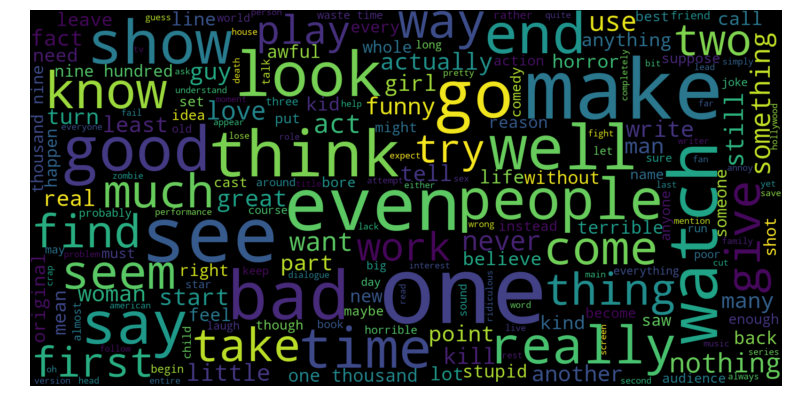

In [5]:
#VISUALIZING MOST FREQUENT WORD IN NEGATIVE OPINIONS
neg_avis = df_transformed[df_transformed['Score']==-1]
neg_avis = [document for document in neg_avis['Avis']]
neg_avis = pd.Series(neg_avis).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_avis)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

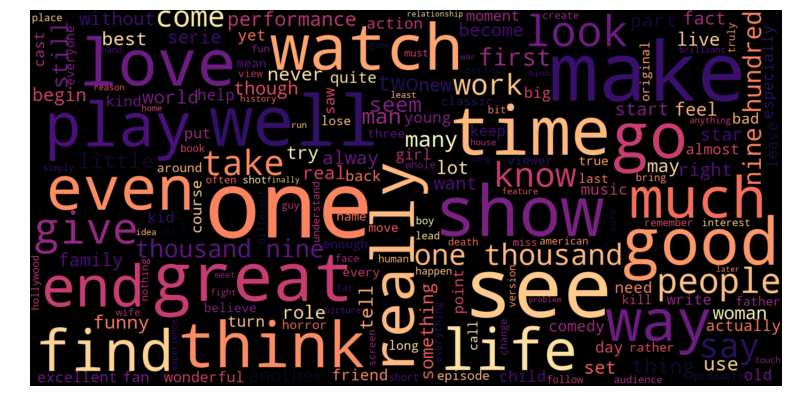

In [6]:
#VISUALIZING MOST FREQUENT WORD IN POSITIVE OPINIONS
pos_avis = df_transformed[df_transformed['Score']==1]
pos_avis = [document for document in pos_avis['Avis']]
pos_avis = pd.Series(pos_avis).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, colormap='magma').generate(pos_avis)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vectorisation
---
Après le pré-traitement de chaque avis dans le dataset, on utilise la technique **BOW** (**Bag of Words**) avec un `TfidfVectorizer()` permettant d'obtenir la matrice des fréquences des termes, en choisissant les mots ayant une fréquence de document (*i.e. Document Frequency*) de 12, et en appliquant l'algorithme n-grams pour 1 et 2 termes

In [7]:
#VECTORIZING
#splitting the dataset prior to vectorization, to prevent memory-related errors during processing
df_first_partition = df_transformed.iloc[:5000]
df_second_partition = df_transformed.iloc[5000:]

#vectorization of the opinions column
vectorizer = TfidfVectorizer(min_df=12, ngram_range=(1,2))
vectors = vectorizer.fit_transform(df_transformed['Avis'])

## Cross-validation scores
---
Une fois la vectorisation effectuée, on prépare un ensemble de modèles à tester (avec leurs paramètres par défaut) en utilisant une cross-validation sur 10 partitions différentes du datasets et la métrique **Accuracy** pour évaluer les performances. On calcule les scores sur chaque partition ainsi que les scores moyens et leurs déviations standards en utilisant la fonction `cross_val_score()`. Le nombre de partitions et leur choix se fait par le biais d'un `KFold` qui sera passé à la fonction `cross_val_score()`.

Les modèles choisis pour effectuer les tests:
1. **Logistic Regression**
2. **Stochastic Gradient Descent Classifier**
3. **Decision Tree Classifier**
4. **Random Forest Classifier**
5. **Gaussian Naive Bayes Classifier**
6. **K Nearest Neighbors Classifier**
7. **Linear SVM Classifier** (**SVM** with a **linear** kernel)

Une fois les modèles testés, on choisira les meilleurs modèles (en termes de score moyen et déviation standard) à calibrer avec un `GridSearchCV`.

In [9]:
#CROSS VALIDATION USING ACCURACY METRIC
#choosing the data (opinions) and target (score) columns in the dataset
X = vectors.toarray()
y = df['Score']

#dictionary containing the models to cross validate using their default parameters
models = {
    'LogisticRegression': LogisticRegression(),
    #'SGDClassifier': SGDClassifier(),
    #'DecisionTreeClassifier': DecisionTreeClassifier(),
    #'RandomForestClassifier': RandomForestClassifier(),
    #'GaussianNB': GaussianNB(),
    #'KNeighborsClassifier': KNeighborsClassifier(),
    'LinearSVC': LinearSVC()
}
#configuring the parameters used by the cross validation function
k_fold = KFold(n_splits=10, shuffle=True, random_state=CV_SEED)

#cross validation using accuracy metric
#for each defined model
for name, model in models.items():
    start_time = time()
    print('Cross validation started at {}'.format(datetime.now()))
    cv_score = cross_val_score(model, X, y, cv=k_fold, scoring=CV_SCORING)
    output = """
    Time taken to complete cross validation of {}: {} seconds
    Accuracy scores over 10 evaluations: {}
    Mean score: {}
    Standard deviation of scores: {}
    """.format(name, time() - start_time, cv_score, cv_score.mean(), cv_score.std())
    
    print(output)

## Résultats de la cross-validation
---
En appliquant la cross-validation sur l'ensemble des modèles choisis, on se retrouve avec les résultats suivants ordonnés par ordre décroissant sur les scores moyens :

Modèle                | Score moyen | Déviation standard
----------------------|-------------|-------------------
LinearSVC             | 92%         | 1%
SGDClassifier         | 92%         | 1%
LogisticRegression    | 91%         | 0.8%
GaussianNB            | 84%         | 1%
RandomForestClassifier| 81%         | 1%
KNeighborsClassifier  | 79%         | 1%
DecisionTreeClassifier| 75%         | 0.8%

À partir de ce tableau, nous avons choisi le modèle **Logistic Regression**, ayant un score d'accuracy de 91% et 0.8% de déviation standard et le modèle **Linear SVM** ayant un score d'accuracy de 92% et 1% de déviation standard. On a pu également choisir le modèle **Stochastic Gradient Descent** au lieu du modèle **SVM** ayant un kernel linéaire.

Afin d'experimenter un peu, nous avons décider de choisir **Gaussian Naive Bayes** aussi pour visualiser l'effet de choisir des modèles probabilistes dans l'analyse des sentiments.

In [44]:
#CROSS VALIDATION RESULTS
# Cross validation started at 2019-04-18 12:38:23.624361
# 
#     Time taken to complete cross validation of LogisticRegression: 6.682977199554443 seconds
#     Accuracy scores over 10 evaluations: [0.914 0.911 0.916 0.922 0.932 0.905 0.933 0.924 0.911 0.921]
#     Mean score: 0.9189
#     Standard deviation of scores: 0.008722958213817153
#
# Cross validation started at 2019-04-18 12:39:27.854962
# 
#     Time taken to complete cross validation of SGDClassifier: 14.247564554214478 seconds
#     Accuracy scores over 10 evaluations: [0.9   0.909 0.92  0.934 0.94  0.907 0.936 0.925 0.913 0.925]
#     Mean score: 0.9209000000000002
#     Standard deviation of scores: 0.01277849756426787
#
# Cross validation started at 2019-04-18 12:40:48.950553
# 
#     Time taken to complete cross validation of DecisionTreeClassifier: 796.7198390960693 seconds
#     Accuracy scores over 10 evaluations: [0.757 0.75  0.763 0.755 0.76  0.739 0.755 0.732 0.751 0.753]
#     Mean score: 0.7515000000000002
#     Standard deviation of scores: 0.008947066558375441
#
# Cross validation started at 2019-04-18 12:59:27.524247
# 
#     Time taken to complete cross validation of RandomForestClassifier: 53.930598735809326 seconds
#     Accuracy scores over 10 evaluations: [0.803 0.815 0.813 0.823 0.819 0.833 0.835 0.814 0.799 0.826]
#     Mean score: 0.818
#     Standard deviation of scores: 0.011135528725660019
#
# Cross validation started at 2019-04-18 12:56:18.964747
# 
#     Time taken to complete cross validation of GaussianNB: 23.15500497817993 seconds
#     Accuracy scores over 10 evaluations: [0.817 0.841 0.829 0.853 0.836 0.838 0.85  0.847 0.833 0.85 ]
#     Mean score: 0.8394
#     Standard deviation of scores: 0.010650821564555487
#
# Cross validation started at 2019-04-18 19:47:55.137561
# 
#     Time taken to complete cross validation of KNeighborsClassifier: 2430.809322834015 seconds
#     Accuracy scores over 10 evaluations: [0.795 0.793 0.805 0.796 0.799 0.778 0.815 0.775 0.817 0.78 ]
#     Mean score: 0.7953
#     Standard deviation of scores: 0.013849548729110253
#
# Cross validation started at 2019-04-18 12:56:42.120080
# 
#     Time taken to complete cross validation of LinearSVC: 6.601022243499756 seconds
#     Accuracy scores over 10 evaluations: [0.913 0.915 0.918 0.926 0.944 0.908 0.938 0.92  0.923 0.925]
#     Mean score: 0.923
#     Standard deviation of scores: 0.010497618777608539

## Calibrage des hyperparamètres des modèles en utilisant un GridSearch
---
Une fois les modèles choisis à partir de l'étape d'évaluation par cross-validation, il faut trouver les meilleurs hyperparamètres permettant de raffiner les régions de décision de chaque modèle afin d'avoir les meilleurs prédictions possibles. Ceci est effectué par un `GridSearchCV`, qui permet de tester différentes combinaisons des valeurs des hyperparamètres fournis dans un dictionnaire, pour chaque modèle.

De plus, `GridSearchCV` permet de répéter le processus sur *K* partitions, pour choisir les meilleurs résultats par cross-validation. Nous choisirons ainsi de répéter le processus sur 5 partitions différentes du dataset et nous utiliserons la métrique **Accuracy** pour évaluer les différents calibrages des modèles.

Pour le modèle **Logistic Regression**, les hyperparamètres à calibrer sont:
1. `C`: la valeur de l'inverse de la régularization pour la régression (sauts de $10^{-k}$ avec $k \in [-4;4]$) 
2. `P`: la norme à choisir pour les pénalités ($L_1$ et $L_2$) 

Pour le modèle **Gaussian Naive Bayes**, il n'existe pas de hyperparamètres à calibrer sauf `priors` désignant les probabilités au préalable estimées pour chacune des classes. Toutefois, nous nous touchons pas à cet hyperparamètre afin qu'il s'adapte dynamiquement au données. (cf. https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

In [10]:
#GRIDSEARCH USING THE ACCURACY METRIC FOR PARAMETERS TUNING

#based on the cross-validation results, using KFold over 10 partitions
#the models LogisticRegression and LinearSVC are best suited for the job
#However, using GaussianNB should also be taken into account, since it's among the most adapted
#for sentiment analysis

#dictionary containing the candidate models that will be used 
#for parameters tuning using a GridSearchCV
candidates = {
    'LogisticRegression': models['LogisticRegression']
    #'LinearSVC': models['LinearSVC']
}

#dictionary of the hyperparameters to be tuned for each model
grid_params = {
    'LogisticRegression': {
        'C': np.logspace(-4,4,20),
        'penalty': ['l1','l2']
    },
    'LinearSVC': {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
}

#generation of training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = TTS_VALIDATION_SIZE,
    test_size = TTS_TEST_SIZE,
    random_state = TTS_SEED
)

#GridSearchCV for every candidate classifier
grid_search_results = []
for name, model in candidates.items():
    #creation of the gridsearch
    grd_sr = GridSearchCV(
        estimator = model,
        param_grid = grid_params[name],
        scoring = GRDSR_SCORING,
        cv = 5,
        n_jobs = -1,
        iid = True,
        return_train_score = True
    )
    
    #execution of the gridsearch
    start_time = time()
    print('Grid search started at {}'.format(datetime.now()))
    grd_sr.fit(X_train, y_train)
    print('\nTime taken to complete Grid search of {}: {} seconds'.format(name, time() - start_time))
    grd_sr_result = GridSearchResult(name, grd_sr.best_score_, grd_sr.best_estimator_)
    print(grd_sr_result)
    grid_search_results.append(grd_sr_result)

#sorting the results by descending order on the score column of the GridSearchResult objects
grid_search_results = sorted(grid_search_results, key=lambda result: result.score, reverse=True)
print('The best model with the best hyperparameters:\n{}'.format(grid_search_results[0]))

Grid search started at 2019-04-19 09:48:26.619439

Time taken to complete Grid search of LogisticRegression: 68.54148316383362 seconds

        Model: LogisticRegression
        Best Accuracy Score: 0.9073333333333333
        Best Estimator: LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
        
The best model with the best hyperparameters:

        Model: LogisticRegression
        Best Accuracy Score: 0.9073333333333333
        Best Estimator: LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
        


In [ ]:
#GRIDSEARCHCV RESULTS
# Grid search started at 2019-04-19 09:48:26.619439
# 
# Time taken to complete Grid search of LogisticRegression: 68.54148316383362 seconds
# 
#         Model: LogisticRegression
#         Best Accuracy Score: 0.9073333333333333
#         Best Estimator: LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
#           fit_intercept=True, intercept_scaling=1, max_iter=100,
#           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
#           solver='warn', tol=0.0001, verbose=0, warm_start=False)
#
# Grid search started at 2019-04-18 20:59:28.571292
# 
# Time taken to complete Grid search of LinearSVC: 16.8770534992218 seconds
# 
#         Model: LinearSVC
#         Best Accuracy Score: 0.9053333333333333
#         Best Estimator: LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0)
# 
# The best model with the best hyperparameters:
# 
#         Model: LogisticRegression
#         Best Accuracy Score: 0.9073333333333333
#         Best Estimator: LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
#           fit_intercept=True, intercept_scaling=1, max_iter=100,
#           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
#           solver='warn', tol=0.0001, verbose=0, warm_start=False)


## Résultats du calibrage avec un GridSearch
---
En appliquant un `GridSearchCV` sur l'ensemble des modèles candidats choisis, on se retrouve avec les résultats suivants ordonnés par ordre décroissant sur les scores moyens :

Modèle                | Score moyen | Meilleurs Résultats des hyperparamètres
----------------------|-------------|----------------------------------------
LogisticRegression    | 90%         | C = 11.288378916846883 ; penalty = $L_2$
LinearSVC             | 90%         | C = 1

À partir de ce tableau, nous avons choisi le modèle **Logistic Regression**, ayant un score d'accuracy de 90% et les hyperparamètres `C` et `penalty` calibrés de la manière suivante : $C = 1$ ; $penalty = L_2$.

## Création d'un Pipeline pour le modèle Logistic Regression
---
Suite au calibrage des hyperparamètres des modèles candidats, on choisit le meilleur modèle calibré avec les meilleurs hyperparamètres pour l'apprentissage et nous créons un pipeline permettant d'enchaîner les étapes de pré-traitement, de vectorisation et d'apprentissage.

Pour la vectorisation, on utilise la technique **BOW** (**Bag of Words**) avec un `TfidfVectorizer()`. On commence par appliquer les fonctions de prétraitement sur chaque document et effectue la vectorisation pour obtenir la matrice des fréquences des termes, en choisissant les mots ayant une fréquence de document (*i.e. Document Frequency*) de 12, et en appliquant l'algorithme n-grams pour 1 et 2 termes.

Pour l'apprentissage on utilise une instance du modèle choisit avec les meilleurs valeurs trouvées pour les hyperparamètres calibrés, notamment le modèle **Logistic Regression**.

Une fois le pipeline executé :
1. on teste le modèle appris
2. on affiche son score de la métrique **Accuracy** en utilisant la fonction `accuracy_score()` 
2. on affiche sa matrice de confusion en utilisant la fonction `confusion_matrix()`
3. on affiche les scores des métriques **Precision**, **Recall**, **F1-Score** et **Support** en utilisant la fonction `classification_report()`

Enfin, on sauvegarde le modèle en utilisant la fonction `dump()` du module `pickle`.

In [13]:
#PIPELINE CREATION FOR LOGISTICREGRESSION CLASSIFIER
#creating the pipeline instance
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess, min_df=12, ngram_range=(1, 2))),
    ('clf', LogisticRegression(C=11.288378916846883, penalty='l2'))
])

#choosing data and target columns from initial dataset
X = df['Avis']
y = df['Score']

#generating the training/test sets from the initial dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = TTS_VALIDATION_SIZE,
    test_size = TTS_TEST_SIZE,
    random_state = TTS_SEED
)

#learning the model using the pipeline
start_time = time()
print('LogisticRegression classifier pipeline execution started at {}'.format(datetime.now()))
lr_pipeline.fit(X_train, y_train)
print('\nTime taken to complete pipeline execution: {} seconds'.format(time() - start_time))

#predicting the targets of test data
start_time = time()
print('\nLogisticRegression classifier prediction started at {}'.format(datetime.now()))
prediction_result = lr_pipeline.predict(X_test)
print('\nTime taken to complete prediction: {} seconds'.format(time() - start_time))

#accuracy, confusion matrix and classification report of the classifier
accuracy = accuracy_score(prediction_result, y_test)
conf = confusion_matrix(y_test, prediction_result)
report = classification_report(y_test, prediction_result)
print('''
Accuracy: {}
Confusion Matrix
{}

Classification Report
{}
'''.format(accuracy, conf, report))

LogisticRegression classifier pipeline execution started at 2019-04-19 11:13:34.840659

Time taken to complete pipeline execution: 31.55421018600464 seconds

LogisticRegression classifier prediction started at 2019-04-19 11:14:06.394955

Time taken to complete prediction: 74.41712045669556 seconds

Accuracy: 0.8995714285714286
Confusion Matrix
[[3110  373]
 [ 330 3187]]

Classification Report
              precision    recall  f1-score   support

          -1       0.90      0.89      0.90      3483
           1       0.90      0.91      0.90      3517

   micro avg       0.90      0.90      0.90      7000
   macro avg       0.90      0.90      0.90      7000
weighted avg       0.90      0.90      0.90      7000




In [18]:
#SAVING LOGISTICREGRESSION PIPELINE
print('Saving the Logistic Regression pipeline')
pickle.dump(lr_pipeline, open(LOGISTICREGRESSION_PATH, 'wb'))

Saving the Logistic Regression pipeline


## Création d'un Pipeline pour le modèle Gaussian Naive Bayes
---
Nous créons aussi un pipeline pour le modèle **Gaussian Naive Bayes** en utilisant les mêmes paramètres utilisés pour la création du pipeline du modèle **Logistic Regression**. À la différence du modèle **Logistic Regression**, **Gaussian Naive Bayes** travaille avec des **matrices denses** (*i.e. dense matrices*) et non pas des **matrices creuses** (*i.e. sparse matrices*).

Il faut ainsi utiliser un transformateur permettant d'effectuer cette étape suite à l'étape de "fitting" du pipeline. On définit ainsi une classe `DenseTransformer` héritant de la classe de base des transformateurs de matrices du module **scikit-learn** `TransformerMixin` accomplissant cette tâche et fournissant le résultat à la phase d'apprentissage.

Une fois le pipeline executé :
1. on teste le modèle appris
2. on affiche son score de la métrique **Accuracy** en utilisant la fonction `accuracy_score()` 
2. on affiche sa matrice de confusion en utilisant la fonction `confusion_matrix()`
3. on affiche les scores des métriques **Precision**, **Recall**, **F1-Score** et **Support** en utilisant la fonction `classification_report()`

Enfin, on sauvegarde le modèle en utilisant la fonction `dump()` du module `pickle`.

In [17]:
#PIPELINE CREATION FOR GAUSSIANNB CLASSIFIER
#creating the pipeline instance
gnb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess, min_df=12, ngram_range=(1, 2))),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())
])

#choosing data and target columns from initial dataset
df_pipeline = df
X = df_pipeline['Avis']
y = df_pipeline['Score']

#generating the training/test sets from the initial dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = TTS_VALIDATION_SIZE,
    test_size = TTS_TEST_SIZE,
    random_state = TTS_SEED
)

#learning the model using the pipeline
start_time = time()
print('GaussianNB classifier pipeline execution started at {}'.format(datetime.now()))
gnb_pipeline.fit(X_train, y_train)
print('\nTime taken to complete pipeline execution: {} seconds'.format(time() - start_time))

#predicting the targets of test data
start_time = time()
print('\nGaussianNB classifier prediction started at {}'.format(datetime.now()))
prediction_result = gnb_pipeline.predict(X_test)
print('\nTime taken to complete prediction: {} seconds'.format(time() - start_time))

#printing the accuracy, confusion matrix and classification report
#of the classifier in the pipeline
accuracy = accuracy_score(prediction_result, y_test)
conf = confusion_matrix(y_test, prediction_result)
report = classification_report(y_test, prediction_result)
print('''
Accuracy: {}
Confusion Matrix
{}

Classification Report
{}
'''.format(accuracy, conf, report))

GaussianNB classifier pipeline execution started at 2019-04-19 11:24:59.808241

Time taken to complete pipeline execution: 34.085160970687866 seconds

GaussianNB classifier prediction started at 2019-04-19 11:25:33.893449

Time taken to complete prediction: 73.48156118392944 seconds

Accuracy: 0.8272857142857143
Confusion Matrix
[[2814  669]
 [ 540 2977]]

Classification Report
              precision    recall  f1-score   support

          -1       0.84      0.81      0.82      3483
           1       0.82      0.85      0.83      3517

   micro avg       0.83      0.83      0.83      7000
   macro avg       0.83      0.83      0.83      7000
weighted avg       0.83      0.83      0.83      7000




In [19]:
#SAVING GAUSSIANNB PIPELINE
print('Saving the Gaussian Naive Bayes pipeline')
pickle.dump(gnb_pipeline, open(GAUSSIANNB_PATH, 'wb'))

Saving the Gaussian Naive Bayes pipeline
